In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics
from torchmetrics import Accuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [ ]:
os.chdir("/content/drive/MyDrive/MovieRecommendationSystem")

In [ ]:
dataset = pd.read_csv("dataset/FeatureExtracted/dataset.csv")
ratings_train = pd.read_csv("dataset/CleanedData/ratings_train.csv")
ratings_test = pd.read_csv("dataset/CleanedData/ratings_test.csv")

# Content-Based Recommendation System - Pytorch

In [ ]:
!pip install torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

**Make Dataset For Train**

There are 671 users



In [ ]:
len_users = len(ratings_train['userId'].unique())
print(len_users)

671


2830 movies



In [ ]:
len_dataset = len(dataset)
print(len_dataset)

2830


We need to save the id for later recommendation



In [ ]:
dataset

,budget,id,runtime,revenue,vote_average,vote_count,CastsRank,NumLeadActors,HasTop50Actors,NumCrews,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,60000000,949,170.0,187436818.0,7.7,1886.0,13415,3,0,71,...,0,0,0,0,0,0,0,1,0,0
1,58000000,710,130.0,352194034.0,6.6,1194.0,6257,3,1,46,...,0,0,0,0,0,0,0,1,0,0
2,98000000,1408,119.0,10017322.0,5.7,137.0,3863,0,0,16,...,0,0,0,0,0,0,0,0,0,0
3,52000000,524,178.0,116112375.0,7.8,1343.0,7062,0,0,10,...,0,0,0,0,0,0,0,0,0,0
4,16500000,4584,136.0,135000000.0,7.2,364.0,4658,2,1,8,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,0,80831,121.0,0.0,6.5,2.0,1621,0,0,4,...,0,0,0,0,0,0,0,0,0,0
2826,0,3104,92.0,0.0,5.9,33.0,1170,0,0,11,...,0,1,0,0,0,1,0,0,0,0
2827,0,64197,97.0,0.0,6.0,5.0,758,0,0,4,...,0,0,0,0,1,0,0,0,0,0
2828,0,98604,91.0,0.0,4.6,6.0,1628,0,0,4,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
indexToId = dict(zip(dataset.index, dataset['id']))
idToIndex = dict(zip(dataset['id'], dataset.index))

In [ ]:
indexToId[0]


949

In [ ]:
dataset.drop(columns = ['id'], inplace = True)


In [ ]:
from sklearn import preprocessing

In [ ]:
dataset = preprocessing.scale(dataset)

In [ ]:
len_features = dataset.shape[1]

Test Transfrom Metadata Movies Dataframe to Tensor



In [ ]:
movies_tensor = torch.tensor(dataset, requires_grad= False)

Test Transform Ratings to Sparse Tensor



In [ ]:
ratings_train["movieId"] = ratings_train["movieId"].apply(lambda x: idToIndex[x])

In [ ]:
ratings_test["movieId"] = ratings_test["movieId"].apply(lambda x: idToIndex[x])

In [ ]:
len(ratings_train['userId'].unique()) == len(ratings_test['userId'].unique())

True

In [ ]:
ratings_train["userId"] = ratings_train["userId"].apply(lambda x: x - 1)
ratings_test["userId"] = ratings_test["userId"].apply(lambda x: x - 1)

In [ ]:
ratings_tensor = torch.sparse_coo_tensor([ratings_train['userId'], ratings_train['movieId']], ratings_train['rating'], (len_users, len_dataset))

All works normally!

Now we will put all those codes into one block

Rating larger than 4.0 will be assigned by 2 else 1. 2 and 1 because we want to avoid the misunderstanding of library with 0 for the unrated one

In [ ]:
ratings_train['rating'] = ratings_train['rating'].apply(lambda x: 2 if x >= 4 else 1)
ratings_test['rating'] = ratings_test['rating'].apply(lambda x: 2 if x >= 4 else 1)

Convert dataset to Tensor data structure


In [ ]:
movies_tensor = torch.tensor(dataset, requires_grad= False)
movies_tensor = torch.cat((movies_tensor, torch.ones(len_dataset, 1, dtype = torch.float64)), axis = 1)
ratings_train_tensor = torch.sparse_coo_tensor([ratings_train['userId'],\
                                                     ratings_train['movieId']],\
                                                     ratings_train['rating'], (len_users, len_dataset))
ratings_test_tensor = torch.sparse_coo_tensor([ratings_test['userId'],\
                                                     ratings_test['movieId']],\
                                                     ratings_test['rating'], (len_users, len_dataset))

ratings_train_tensor = ratings_train_tensor.to_dense()
ratings_test_tensor = ratings_test_tensor.to_dense()

In [ ]:
from torch.autograd import Variable

In [ ]:
ratings_train_tensor[0][474]

tensor(0)

We proposed a Classification Model for predicting Ratings

To predict the rate from user model ***U*** and movies profiles ***M***:

***U * Mᵀ = R̂***

***L = BCE(R̂, R)*** for all movies that have rating

Find the partial derivatives for matrix ***U***: ***$\frac{∂L}{∂U}$***

Update ***U*** based on **$\frac{∂L}{∂U}$**

To calculate derivatives, we use **Autograd** of ***Pytorch***

In [ ]:
"""
Autograd example
"""
# ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
# mask = ratings_train_tensor.bool()
# nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
# nonzero_train = ratings_train_tensor.masked_select(mask)
# loss = criterion(nonzero_pred, nonzero_train)
# loss.backward()

'\nAutograd example\n'

In [ ]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

Here we use BCELoss (Binary Cross Entropy Loss) for classification 0 and 1

Metrics use is *accuracy*.

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([U], lr = 0.005)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
bestU = None
bestb = None
maxAcc = 0.0

First try 3001 loop without regulization, lr = 0.005

In [ ]:
EPOCH = 3001
a = Accuracy(task = "binary")
trainLoss = []
testLoss = []
testEp = []
trainAcc = []
testAcc =[]
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
    nonzero_train = ratings_train_tensor.masked_select(mask)
    nonzero_train = nonzero_train - 1
    loss = criterion(nonzero_pred, nonzero_train.double())
    accuracy = a(nonzero_pred, nonzero_train.int())
    loss.backward()
    optimizer.step()

    trainLoss.append(loss.item())
    trainAcc.append(accuracy.item())
    if ep % 10 == 0:
      mask = ratings_test_tensor.bool()
      nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
      nonzero_test = ratings_test_tensor.masked_select(mask)
      nonzero_test = nonzero_test - 1
      loss_test = criterion(nonzero_pred, nonzero_test.double())
      accuracy_test = a(nonzero_pred, nonzero_test.int())

      testEp.append(ep)
      testLoss.append(loss_test.item())
      testAcc.append(accuracy_test.item())
      
      if maxAcc < accuracy_test:
        bestU = U
        bestb = b
        maxAcc = accuracy_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Train Acc: {accuracy}. Valid Loss: {loss_test}. Valid Acc: {accuracy_test}.')

  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 2.477557531569982. Train Acc: 0.5020198822021484. Valid Loss: 2.5256281768048208. Valid Acc: 0.49858686327934265.
Epoch: 10. Train Loss: 2.286706015093386. Train Acc: 0.5117024779319763. Valid Loss: 2.416220542972691. Valid Acc: 0.5009058713912964.
Epoch: 20. Train Loss: 2.115631125113655. Train Acc: 0.5213209390640259. Valid Loss: 2.3182856026637744. Valid Acc: 0.5026451349258423.
Epoch: 30. Train Loss: 1.9555021423887113. Train Acc: 0.5317088961601257. Valid Loss: 2.235041232317717. Valid Acc: 0.5049641132354736.
Epoch: 40. Train Loss: 1.8111564494824723. Train Acc: 0.5439884662628174. Valid Loss: 2.16088171435933. Valid Acc: 0.5060511827468872.
Epoch: 50. Train Loss: 1.6815330472232604. Train Acc: 0.5539275407791138. Valid Loss: 2.0948020134258605. Valid Acc: 0.5072106719017029.
Epoch: 60. Train Loss: 1.5637447289676807. Train Acc: 0.5656941533088684. Valid Loss: 2.0313460405304444. Valid Acc: 0.5094572305679321.
Epoch: 70. Train Loss: 1.4570320667812702. Train

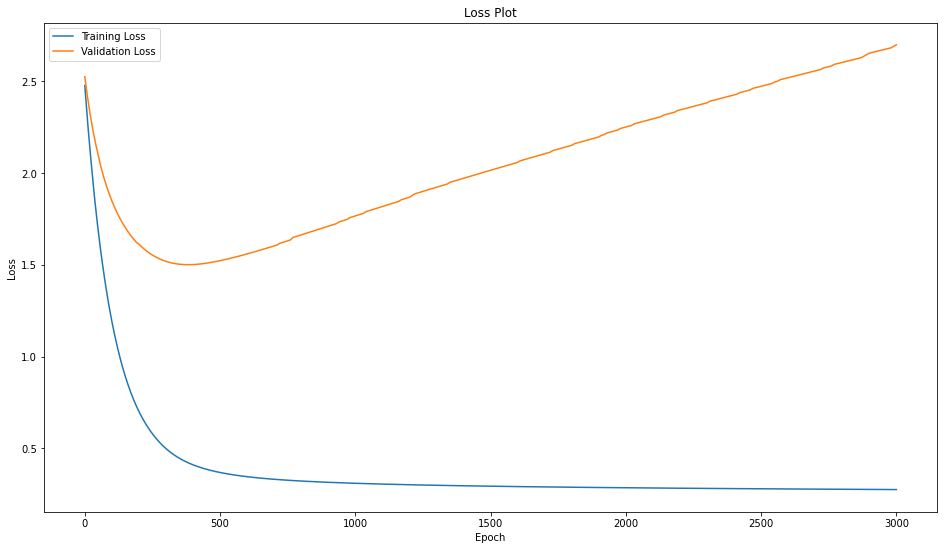

In [ ]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

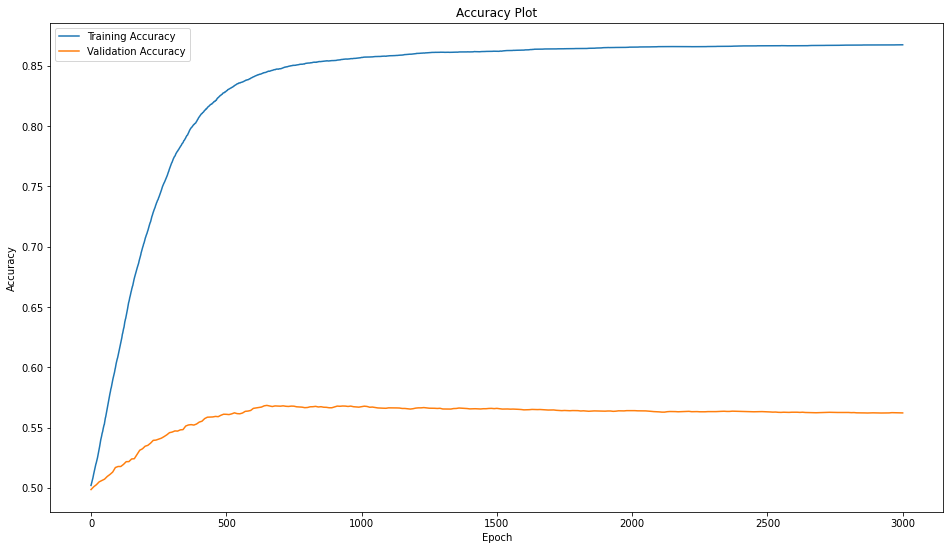

In [ ]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainAcc, label='Training Accuracy')
plt.plot(testEp, testAcc, label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim((0.0,1.0))
plt.legend()

Now apply regularization with lr = 0.005, weight_decay for U is 0.05



In [ ]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([U], lr = 0.005, weight_decay = 0.005)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [ ]:
bestU = None
bestb = None
maxAcc = 0.0

In [ ]:
EPOCH = 3001
a = Accuracy(task = "binary")
trainLoss = []
testLoss = []
testEp = []
trainAcc = []
testAcc = []
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
    nonzero_train = ratings_train_tensor.masked_select(mask)
    nonzero_train = nonzero_train - 1
    loss = criterion(nonzero_pred, nonzero_train.double())
    accuracy = a(nonzero_pred, nonzero_train.int())
    loss.backward()
    optimizer.step()

    trainLoss.append(loss.item())
    trainAcc.append(accuracy.item())
    if ep % 10 == 0:
      mask = ratings_test_tensor.bool()
      nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
      nonzero_test = ratings_test_tensor.masked_select(mask)
      nonzero_test = nonzero_test - 1
      loss_test = criterion(nonzero_pred, nonzero_test.double())
      accuracy_test = a(nonzero_pred, nonzero_test.int())

      testEp.append(ep)
      testLoss.append(loss_test.item())
      testAcc.append(accuracy_test.item())
      
      if maxAcc < accuracy_test:
        bestU = U
        bestb = b
        maxAcc = accuracy_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Train Acc: {accuracy}. Valid Loss: {loss_test}. Valid Acc: {accuracy_test}.')

  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 2.5629537173484858. Train Acc: 0.49454954266548157. Valid Loss: 2.5625006406023396. Valid Acc: 0.4946735203266144.
Epoch: 10. Train Loss: 2.4516600457056175. Train Acc: 0.49515870213508606. Valid Loss: 2.4571220846728083. Valid Acc: 0.49619537591934204.
Epoch: 20. Train Loss: 2.3422145324743617. Train Acc: 0.49695414304733276. Valid Loss: 2.3556207943678857. Valid Acc: 0.4983694553375244.
Epoch: 30. Train Loss: 2.2375759615022535. Train Acc: 0.49849310517311096. Valid Loss: 2.2492761774335825. Valid Acc: 0.4998188316822052.
Epoch: 40. Train Loss: 2.1399071545479367. Train Acc: 0.5. Valid Loss: 2.156832905619309. Valid Acc: 0.5006160140037537.
Epoch: 50. Train Loss: 2.0470515230345487. Train Acc: 0.5016992688179016. Valid Loss: 2.0692445613404424. Valid Acc: 0.5014855861663818.
Epoch: 60. Train Loss: 1.9589925660206677. Train Acc: 0.5047130584716797. Valid Loss: 1.98159194709792. Valid Acc: 0.5027900338172913.
Epoch: 70. Train Loss: 1.8774944841967953. Train Acc: 0

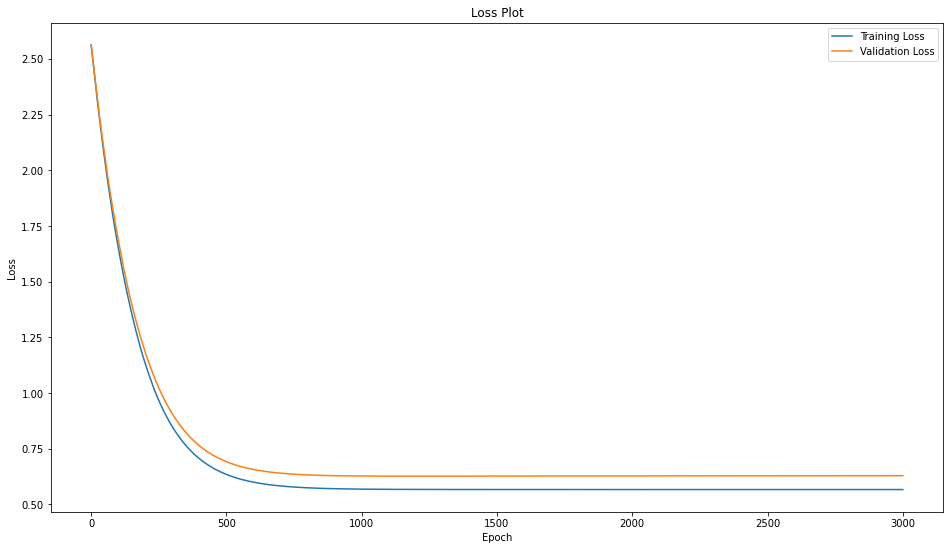

In [ ]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

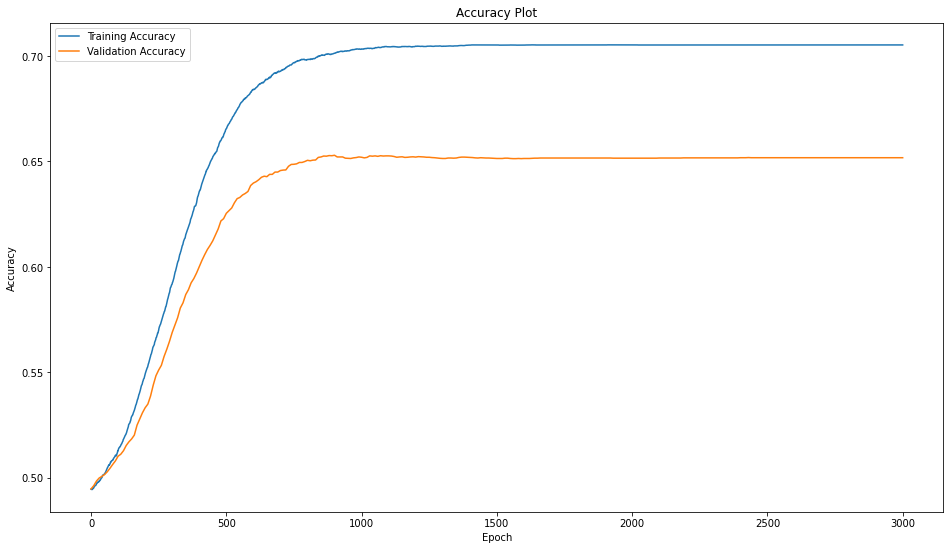

In [ ]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainAcc, label='Training Accuracy')
plt.plot(testEp, testAcc, label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim((0.0,1.0))
plt.legend()

In [ ]:
maxAcc

tensor(0.6529)

In [ ]:
bestU

tensor([[ 5.9797e-05, -5.9540e-05,  6.0340e-05,  ...,  1.2566e-04,
          3.9775e-05,  3.2999e-05],
        [-2.8223e-03, -3.8681e-02,  8.3772e-03,  ...,  1.8870e-02,
          4.6792e-03, -1.5940e-17],
        [ 7.4875e-03,  1.5098e-03, -9.5267e-04,  ..., -2.0620e-03,
          1.9395e-06,  3.7287e-11],
        ...,
        [ 7.5840e-03,  7.5139e-03,  3.5878e-03,  ...,  8.5475e-03,
          1.1335e-11,  1.5263e-15],
        [ 8.5088e-03,  2.8262e-03,  2.5930e-03,  ..., -6.5549e-03,
          1.9199e-02, -2.3723e-17],
        [ 4.2889e-03,  7.7337e-03,  1.7751e-03,  ...,  4.8423e-03,
          4.0467e-03,  9.9071e-03]], dtype=torch.float64, requires_grad=True)

In [ ]:
bestU.detach().numpy().tofile("dataset/ModelStorage/U.txt")
bestb.detach().numpy().tofile("dataset/ModelStorage/b.txt")

In [ ]:
with open("dataset/ModelStorage/indexToId.txt", "w+") as file:
  file.write(str(indexToId))
with open("dataset/ModelStorage/idToIndex.txt", "w+") as file:
  file.write(str(idToIndex))